In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 定义步长 K
TIME_STEP = 2
INPUT_DIM = 1
output_dim = 1
batch_size = 10  # 每轮训练模型时，样本的数量
epochs = 20  # 训练60轮次
hidden_size = 32
layer_num = 2

In [3]:
chunksize = 720 # 数据特征保证了一个服务只有720行数据
reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRTQps_sort.csv", chunksize=chunksize)


In [4]:
df = pd.DataFrame()
index = 0
# 循环读取每个数据块并添加到DataFrame中
for index, chunk in enumerate(reader):
        if index > 1:
            break
        df = pd.concat([df, chunk])


In [5]:
df.head(100)

,Unnamed: 0,msinstanceid,timestamp,HTTP_MCR,HTTP_RT
0,0,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,0,7.195093,7.195093
1,22430,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,60000,7.118115,7.118115
2,44840,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,120000,6.985224,6.985224
3,67235,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,180000,7.654883,7.654883
4,89612,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,240000,7.217251,7.217251
...,...,...,...,...,...
95,2144226,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5700000,7.159023,7.159023
96,2166891,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5760000,6.933686,6.933686
97,2189593,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5820000,6.938315,6.938315
98,2212252,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5880000,7.534233,7.534233


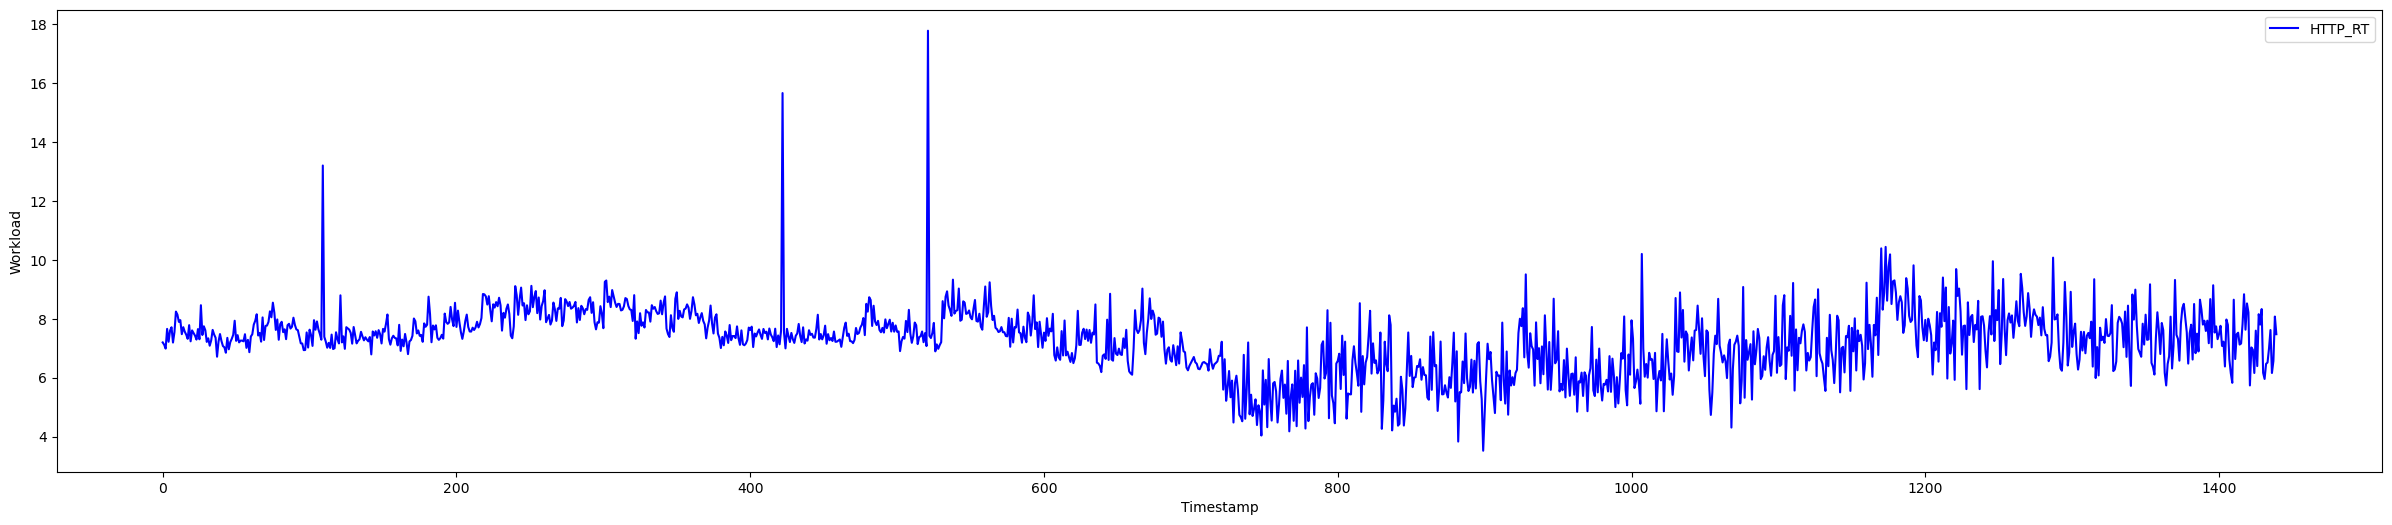

In [6]:
plt.figure(figsize=(30, 6))
plt.plot(df["HTTP_RT"], label="HTTP_RT", color='blue')

plt.xlabel("Timestamp")
plt.ylabel("Workload")
plt.legend()
plt.show()

In [7]:
import pywt

# 小波滤噪
def wavelet_denoising_4(data):
    # 小波函数取db8
    db4 = pywt.Wavelet('db8')

    # 分解
    coeffs = pywt.wavedec(data, db4)
    # 高频系数置零
    coeffs[len(coeffs)-1] *= 0
    coeffs[len(coeffs)-2] *= 0
    # 重构
    meta = pywt.waverec(coeffs, db4)
    return meta
 
# 小波滤噪
def wavelet_denoising_8(data):
    # 小波函数取db4
    db4 = pywt.Wavelet('db8')

    # 分解
    coeffs = pywt.wavedec(data, db4)
    # 高频系数置零
    coeffs[len(coeffs)-1] *= 0.5
    coeffs[len(coeffs)-2] *= 0.5
    # 重构
    meta = pywt.waverec(coeffs, db4)
    return meta


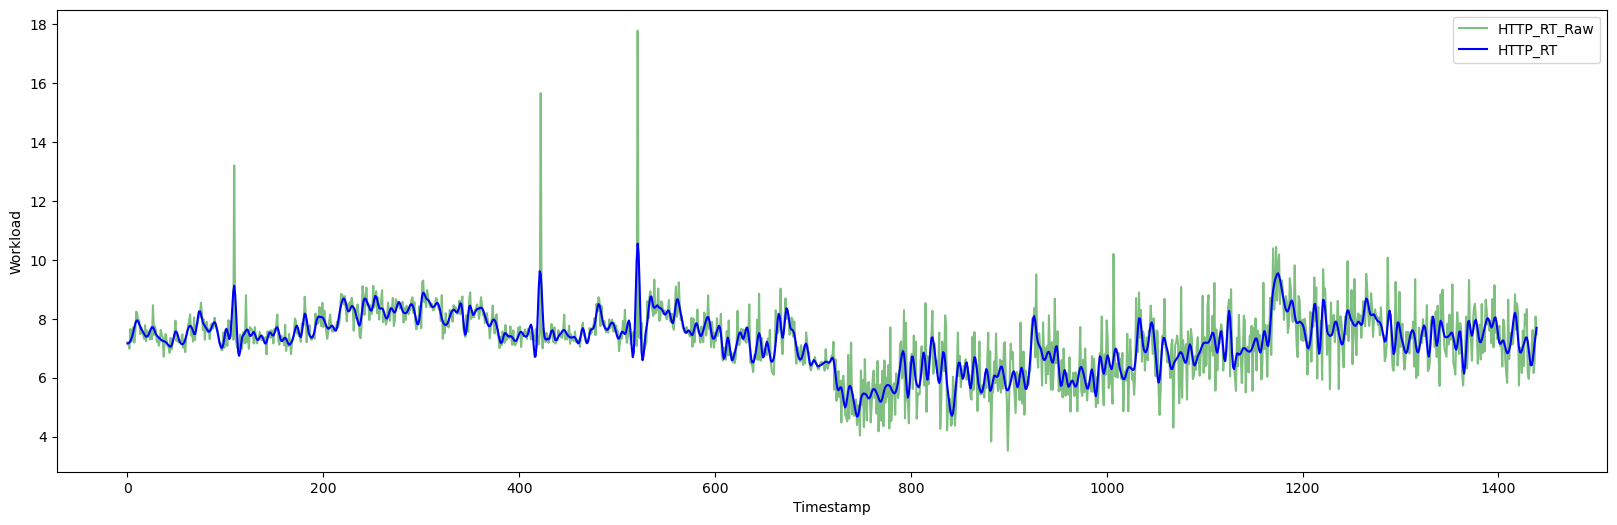

In [8]:

plt.figure(figsize=(20, 6))
plt.plot(df["HTTP_RT"], label="HTTP_RT_Raw", color='green', alpha=0.5)
plt.plot(wavelet_denoising_4(df["HTTP_RT"]), label="HTTP_RT", color='blue')
# plt.plot(wavelet_denoising_8( df["HTTP_RT"][:200]), label="HTTP_RT", color='red')

plt.xlabel("Timestamp")
plt.ylabel("Workload")
plt.legend()
plt.show()


In [9]:
df["HTTP_RT"]=wavelet_denoising_4( df["HTTP_RT"])

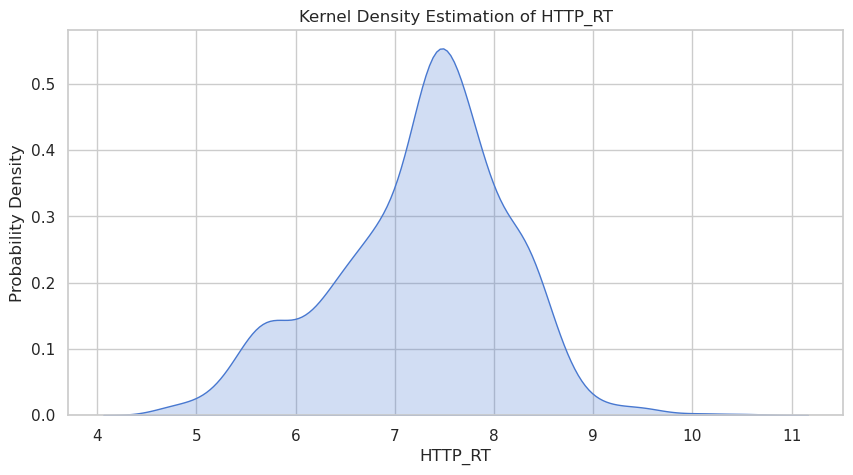

In [10]:
# 绘制数据分布图
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', palette='muted')
sns.kdeplot(data=df, x='HTTP_RT',  fill=True)
plt.xlabel('HTTP_RT')
plt.ylabel('Probability Density')
plt.title('Kernel Density Estimation of HTTP_RT')
plt.show()


In [11]:
df.head(100)

,Unnamed: 0,msinstanceid,timestamp,HTTP_MCR,HTTP_RT
0,0,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,0,7.195093,7.163261
1,22430,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,60000,7.118115,7.163901
2,44840,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,120000,6.985224,7.194036
3,67235,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,180000,7.654883,7.246231
4,89612,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,240000,7.217251,7.318190
...,...,...,...,...,...
95,2144226,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5700000,7.159023,7.069699
96,2166891,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5760000,6.933686,7.005441
97,2189593,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5820000,6.938315,7.032208
98,2212252,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,5880000,7.534233,7.154725


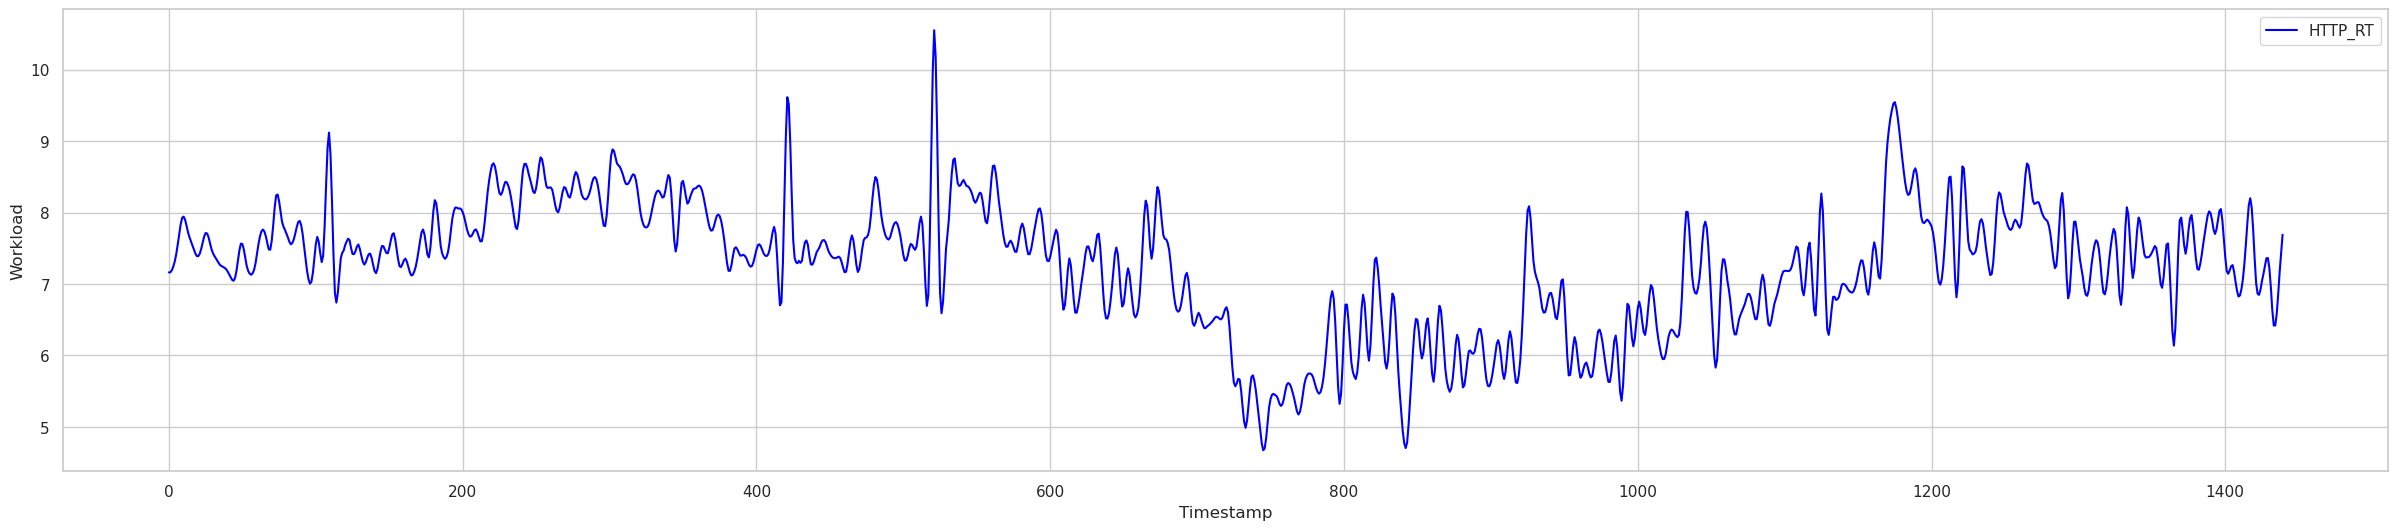

In [12]:
plt.figure(figsize=(30, 6))
plt.plot(df["HTTP_RT"], label="HTTP_RT", color='blue')

plt.xlabel("Timestamp")
plt.ylabel("Workload")
plt.legend()
plt.show()

In [13]:
def split_array_by_step(df, K):

    df['Max_HTTP_RT'] = df['HTTP_RT'].rolling(window=K).max()
    df['Min_HTTP_RT'] = df['HTTP_RT'].rolling(window=K).min()
    df['Mean_HTTP_RT'] = df['HTTP_RT'].rolling(window=K).mean()
    df = df[["HTTP_RT",	"Max_HTTP_RT",	"Min_HTTP_RT",	"Mean_HTTP_RT"]]
    df = df.iloc[K:]

    if len(df) == 0:
        return []

    scaler = MinMaxScaler()
    df[["HTTP_RT", "Max_HTTP_RT", "Min_HTTP_RT", "Mean_HTTP_RT"]] = scaler.fit_transform(
        df[["HTTP_RT", "Max_HTTP_RT", "Min_HTTP_RT", "Mean_HTTP_RT"]])

    # 遍历 DataFrame 的每一行，跳过前 K 行
    result = []
    for i in range(0, len(df) - K, 1):
        window = df.iloc[i:i+K]
        result.append(window)

    return result


In [14]:
# 按照 msinstanceid 列分组
grouped_df = df.groupby('msinstanceid')

http_rt_df = grouped_df.apply(
    lambda x: split_array_by_step(x, TIME_STEP+1))

In [15]:
http_rt_df[0][2]

,HTTP_RT,Max_HTTP_RT,Min_HTTP_RT,Mean_HTTP_RT
5,0.249396,0.243929,0.241427,0.243698
6,0.281067,0.275831,0.261512,0.270383
7,0.315981,0.310999,0.290303,0.303465


In [16]:
workload = np.concatenate(http_rt_df, axis=0)
workload.shape

(1428, 3, 4)

In [17]:
# 将数据转换为LSTM模型的输入形式
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data)):
        xs.append(data[i][:time_steps])
        ys.append(data[i][time_steps])
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(workload, TIME_STEP)

In [18]:
print(x_train.shape)
print(y_train.shape)

(1428, 2, 4)
(1428, 4)


In [19]:
train_size = int(len(x_train) * 0.6)
val_size = int(len(x_train) * 0.2)
test_size = len(x_train) - train_size-val_size

x_train, x_val, x_test = x_train[:train_size, :, :], x_train[train_size:train_size +
                                                             val_size, :, :], x_train[train_size+val_size:, :, :]
y_train, y_val, y_test = y_train[:train_size], y_train[train_size:train_size +
                                                       val_size], y_train[train_size+val_size:]


In [20]:
# 定义步长 K
TIME_STEP = 5
INPUT_DIM =4
output_dim = 4
batch_size = 10  # 每轮训练模型时，样本的数量
epochs = 50  # 训练60轮次
hidden_size = 128
layer_num = 4
patience = 10


In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [22]:
def validate(model, criterion, dataloader):
    running_loss = 0.0
    total_samples = 0

    for batch_x, batch_y in dataloader:
        output = model(batch_x)
        loss = criterion(output, batch_y)

        running_loss += loss.item() * batch_x.size(0)
        total_samples += batch_x.size(0)

    epoch_loss = running_loss / total_samples

    return epoch_loss

In [23]:
def train_model(train_x, train_y, val_x, val_y, model, epochs, batch_size, device, patience=3):
    train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
    train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
    dataset = TensorDataset(train_x, train_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    val_x = torch.tensor(val_x, dtype=torch.float32).to(device)
    val_y = torch.tensor(val_y, dtype=torch.float32).to(device)
    val_dataset = TensorDataset(val_x, val_y)
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    scheduler = ReduceLROnPlateau(optimizer, patience=patience, verbose=True)

    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        epoch_loss = running_loss / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")

        # 在每个epoch后进行验证
        with torch.no_grad():
            val_loss = validate(model, criterion, val_dataloader)
            print(f"Validation Loss: {val_loss:.6f}")

            # 更新学习率
            scheduler.step(val_loss)

    return model


In [24]:
def predict(model, predict_x, device):
    predict_x = torch.tensor(predict_x, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(predict_x)
    return y_pred.cpu().numpy()

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm_model = LSTMModel(INPUT_DIM, hidden_size,
                       layer_num, output_dim).to(device)

lstm_model_trained = train_model(x_train, y_train, x_val, y_val, lstm_model,
                                 50, batch_size, device, patience=patience)


Epoch 1/50, Loss: 0.028532
Validation Loss: 0.006603
Epoch 2/50, Loss: 0.006510
Validation Loss: 0.004236
Epoch 3/50, Loss: 0.005625
Validation Loss: 0.004240
Epoch 4/50, Loss: 0.004776
Validation Loss: 0.004575
Epoch 5/50, Loss: 0.004401
Validation Loss: 0.003429
Epoch 6/50, Loss: 0.003533
Validation Loss: 0.002857
Epoch 7/50, Loss: 0.002857
Validation Loss: 0.002423
Epoch 8/50, Loss: 0.002152
Validation Loss: 0.002294
Epoch 9/50, Loss: 0.001820
Validation Loss: 0.003757
Epoch 10/50, Loss: 0.001979
Validation Loss: 0.001673
Epoch 11/50, Loss: 0.001499
Validation Loss: 0.001489
Epoch 12/50, Loss: 0.001396
Validation Loss: 0.001450
Epoch 13/50, Loss: 0.001204
Validation Loss: 0.001207
Epoch 14/50, Loss: 0.001191
Validation Loss: 0.002122
Epoch 15/50, Loss: 0.001032
Validation Loss: 0.001957
Epoch 16/50, Loss: 0.001022
Validation Loss: 0.001928
Epoch 17/50, Loss: 0.000974
Validation Loss: 0.001538
Epoch 18/50, Loss: 0.000838
Validation Loss: 0.001394
Epoch 19/50, Loss: 0.001092
Validatio

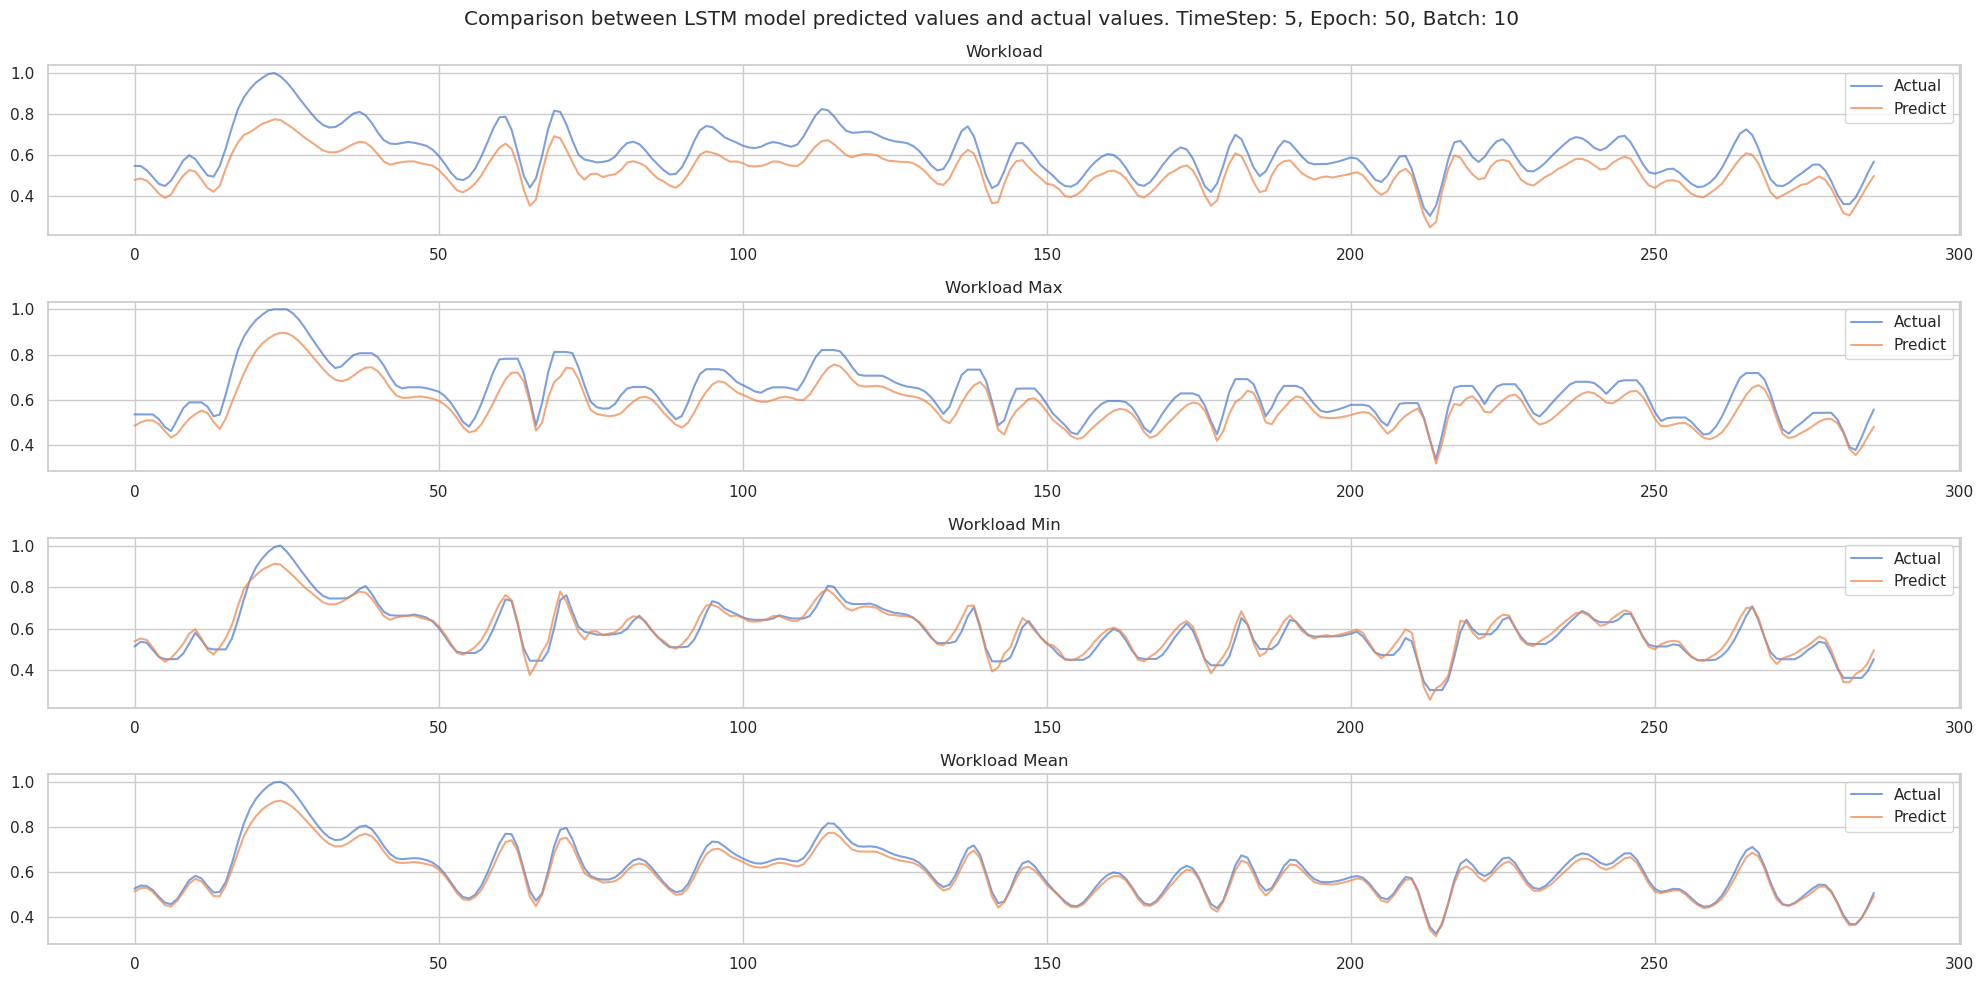

In [26]:
lstm_pred = predict(lstm_model_trained, x_test, device)
y_pred = lstm_pred

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))
axes = axes.flatten()


ax = axes[0]
ax.plot(y_test[:, 0], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 0], label='Predict', alpha=0.7)
ax.set_title(f'Workload')
ax.legend()


ax = axes[1]
ax.plot(y_test[:, 1], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 1], label='Predict', alpha=0.7)
ax.set_title(f'Workload Max')
ax.legend()

ax = axes[2]
ax.plot(y_test[:, 2], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 2], label='Predict', alpha=0.7)
ax.set_title(f'Workload Min')
ax.legend()

ax = axes[3]
ax.plot(y_test[:, 3], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 3], label='Predict', alpha=0.7)
ax.set_title(f'Workload Mean')
ax.legend()


fig.suptitle('Comparison between LSTM model predicted values and actual values. TimeStep: {timestep}, Epoch: {epoch}, Batch: {batch}'.format(
    timestep=TIME_STEP, epoch=epochs, batch=batch_size))
plt.tight_layout()
plt.show()
